Running on CPU...


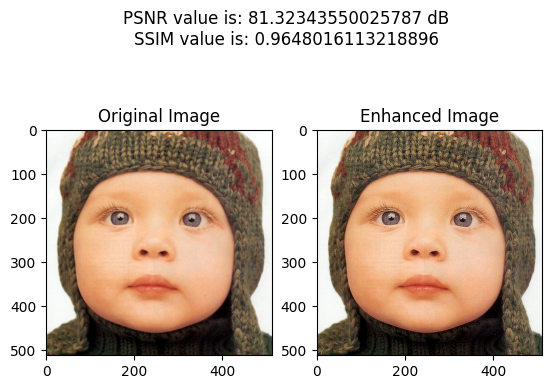

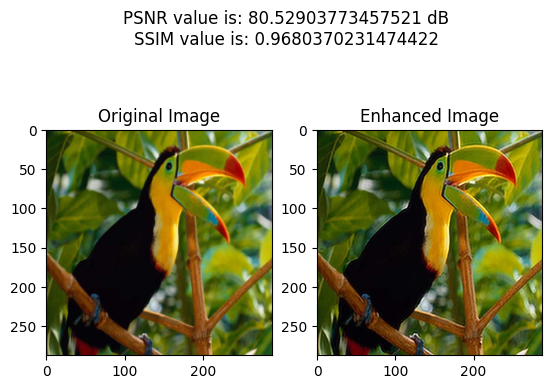

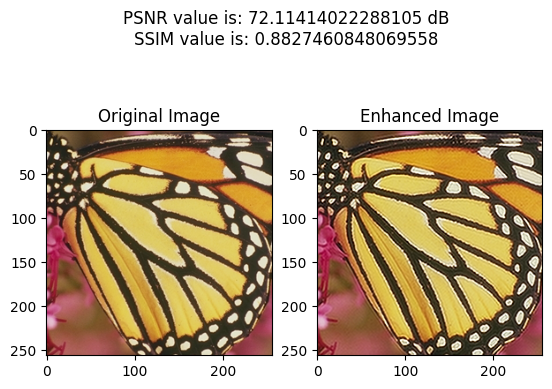

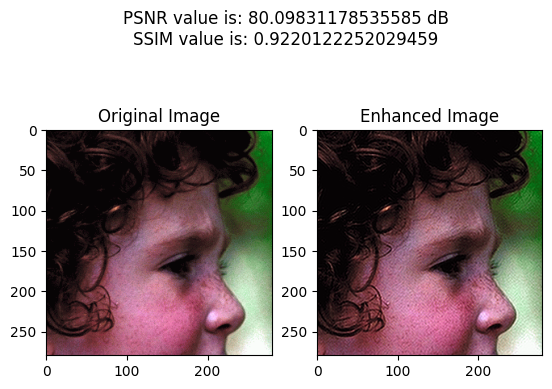

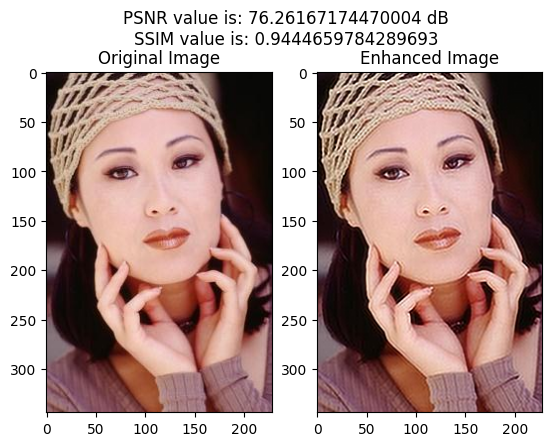

In [2]:
import mindspore as ms
import mindspore.nn as nn
from mindspore import context, Tensor
from mindspore.train.model import Model
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import mindspore.ops as ops
import PIL.Image as pil_image
import numpy as np
from srcnn import SRCNN
from utils import convert_rgb_to_ycbcr, convert_ycbcr_to_rgb
from model_utils.config import config
from skimage import io,color
from skimage import img_as_float
from skimage.metrics import structural_similarity as SSIM
import glob
import matplotlib.pyplot as plt

def calculate_psnr(image_true, image_test):
    """
    计算两幅图像的PSNR。

    参数:
    image_true: 真实图像的numpy数组
    image_test: 测试图像的numpy数组

    返回:
    PSNR值
    """
    # 确保图像数据在0-255范围内并转换为灰度（如果已经是单通道则不需要转换）
    if image_true.shape[-1] == 3:  # 如果是RGB图像
        image_true = color.rgb2gray(image_true)
    if image_test.shape[-1] == 3:  # 同上
        image_test = color.rgb2gray(image_test)

    # 计算MSE
    mse = np.mean((image_true - image_test) ** 2)

    # 防止除以零错误
    if mse == 0:
        return float('inf')  # MSE为0意味着两张图片完全相同

    # 计算PSNR
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    return psnr

def calculate_ssim(image_true, image_test):
    """
    计算两幅图像的SSIM。

    参数:
    image_true: 真实图像的numpy数组
    image_test: 测试图像的numpy数组

    返回:
    SSIM值
    """
    # 确保图像数据在0-1范围内并转换为浮点型
    image_true = img_as_float(image_true)
    image_test = img_as_float(image_test)

    # 如果是RGB图像，转换为灰度图像
    if image_true.shape[-1] == 3:  # 如果是RGB图像
        image_true = color.rgb2gray(image_true)
    if image_test.shape[-1] == 3:  # 同上
        image_test = color.rgb2gray(image_test)

    # 计算SSIM
    window_size = 11  # 可以调整此参数，但必须是奇数
    ssim_value = SSIM(image_true, image_test, win_size=window_size, channel_axis=-1)

    return ssim_value

def run_test():
    """
    运行测试函数，用于加载模型参数，对指定图像进行增强，并计算增强后的图像与原图的PSNR值。

    该函数不接受参数，也不返回任何值。
    """

    # 加载配置信息
    cfg = config
    # 根据配置确定运行环境（CPU或GPU），不支持GPU则抛出异常
    if cfg.device_target == "CPU":
        print("Running on CPU...")
        context.set_context(mode=context.GRAPH_MODE,
                            device_target=cfg.device_target,
                            save_graphs=False)
    else:
        raise ValueError("Unsupported device target.")

    # 初始化网络、优化器和损失函数
    net = SRCNN()
    lr = Tensor(config.lr, ms.float32)
    opt = nn.Adam(params=net.trainable_params(), learning_rate=lr, eps=1e-07)
    loss = nn.MSELoss(reduction='mean')

    # 加载模型参数
    param_dict = load_checkpoint("output\\train\\ckpt_0\\srcnn-40_375.ckpt")
    load_param_into_net(net, param_dict)
    net.set_train(False)
    # 创建模型
    model = Model(net, loss_fn=loss, optimizer=opt)

    # 定义测试图像路径
    images_dir = "Set5"
    for image_path in sorted(glob.glob('{}/*'.format(images_dir))):
        image = pil_image.open(image_path).convert('RGB')
        image = np.array(image).astype(np.float32)
        ycbcr = convert_rgb_to_ycbcr(image)

        # 准备输入数据
        y = ycbcr[..., 0]
        y /= 255.
        y = Tensor.from_numpy(y)
        expand_dims = ops.ExpandDims()
        y = expand_dims(expand_dims(y, 0), 0)
        # 进行预测
        preds = model.predict(y)
        preds = preds.asnumpy()
        # 处理输出图像
        preds = np.multiply(preds, 255.0)
        preds = preds.squeeze(0).squeeze(0)
        output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
        output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
        result = output
        output = pil_image.fromarray(output)


        # 保存处理后的图像
        output.save(image_path.replace('.', '_srcnn_x{}.'.format(config.scale)))


        true_image = io.imread(image_path)

        psnr_value = calculate_psnr(true_image, result)
        ssim_value = calculate_ssim(true_image, result)

        plt.subplot(1, 2, 1)
        plt.imshow(true_image)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.title('Enhanced Image')
        plt.imshow(output)
        plt.suptitle(f'PSNR value is: {psnr_value} dB\nSSIM value is: {ssim_value}')
        plt.show()



if __name__ == '__main__':
    run_test()